<a href="https://colab.research.google.com/github/pippahtlin/Extreme-Precipitation/blob/main/pretrained_univariate_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import MinMaxScaler

In [28]:
df = pd.read_csv("https://raw.githubusercontent.com/pippahtlin/Extreme-Precipitation/main/data/precipitation_soi",index_col = "date")
df.index = pd.to_datetime(df.index)
df

,year,month,day,daily rain,binary rain,soi
date,,,,,,
1899-10-11,1899,10,11,3.048000,0,-1
1899-10-12,1899,10,12,2.032000,0,-1
1899-10-13,1899,10,13,33.020000,1,-1
1899-10-14,1899,10,14,0.508000,0,-1
1899-10-15,1899,10,15,0.000000,0,-1
...,...,...,...,...,...,...
2022-12-27,2022,12,27,0.000000,0,1
2022-12-28,2022,12,28,22.859999,0,1
2022-12-29,2022,12,29,0.000000,0,1


In [29]:
"""
# Count rain days
monthly_rain = df[df['daily rain'] != 0].groupby([pd.Grouper(freq='M')]).size()
monthly_rain = monthly_rain.reset_index(name='rain_days')
monthly_rain['year'], monthly_rain['month'] = monthly_rain['date'].dt.year, monthly_rain['date'].dt.month
monthly_rain
"""

"\n# Count rain days\nmonthly_rain = df[df['daily rain'] != 0].groupby([pd.Grouper(freq='M')]).size()\nmonthly_rain = monthly_rain.reset_index(name='rain_days')\nmonthly_rain['year'], monthly_rain['month'] = monthly_rain['date'].dt.year, monthly_rain['date'].dt.month\nmonthly_rain\n"

In [30]:
# Calculate indices for splitting
total_rows = len(df)
train_end = int(total_rows * 0.6)
validation_end = train_end + int(total_rows * 0.2)

# Using iloc for integer-location based indexing
train = df[["daily rain"]].iloc[:train_end]
validation = df[["daily rain"]].iloc[train_end:validation_end]
test = df[["daily rain"]].iloc[validation_end:]

In [31]:
# upper = 80
sc = MinMaxScaler(feature_range=(0,80))
train_scaled = sc.fit_transform(train)
validation_scaled = sc.transform(validation)
test_scaled = sc.transform(test)

print(type(train_scaled))
train_scaled

<class 'numpy.ndarray'>


array([[ 1.38129496],
       [ 0.92086331],
       [14.96402878],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [32]:
T = 90 # Consider seasonality

# Train
X_train = []
y_train = []
for i in range(T,train_scaled.shape[0]):
    X_train.append(train_scaled[i-T:i])
    y_train.append(train_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Validation
X_validation = []
y_validation = []

for i in range(T, validation_scaled.shape[0]):
    X_validation.append(validation_scaled[i-T:i])
    y_validation.append(validation_scaled[i])
X_validation, y_validation = np.array(X_validation), np.array(y_validation)

X_test = []
y_test = []
for i in range(T, test_scaled.shape[0]):
    X_test.append(test_scaled[i-T:i])
    y_test.append(test_scaled[i])
X_test, y_test = np.array(X_test), np.array(y_test)

# M, T, N
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

(26914, 90, 1) (26914, 1)
(8911, 90, 1) (8911, 1)
(8912, 90, 1) (8912, 1)


In [33]:
from keras import models
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras import metrics
from time import time

<br>

## Import the pre-trained models on github

### 1. Upper bound 80 + epoch 50:
a) Precipitation prediction

In [34]:
model = models.load_model('/content/drive/MyDrive/Extreme Precipitation/Models/model_upper80.h5')

In [35]:
validation_predictions = model.predict(X_validation)
validation_predictions = sc.inverse_transform(validation_predictions)
validation_actual = sc.inverse_transform(y_validation.reshape(-1,1))
# Create validation dataset
validation_compare = pd.DataFrame({'Actual': validation_actual.flatten(), 'Predicted': validation_predictions.flatten()})
# Turn negative prediction to 0
validation_compare['Predicted'] = validation_compare['Predicted'].clip(lower=0)


test_predictions = model.predict(X_test)
test_predictions = sc.inverse_transform(test_predictions)
test_actual = sc.inverse_transform(y_test.reshape(-1,1))
# Create validation dataset
test_compare = pd.DataFrame({'Actual': test_actual.flatten(), 'Predicted': test_predictions.flatten()})
# Turn negative prediction to 0
test_compare['Predicted'] = test_compare['Predicted'].clip(lower=0)

279/279 [==============================] - 6s 20ms/step


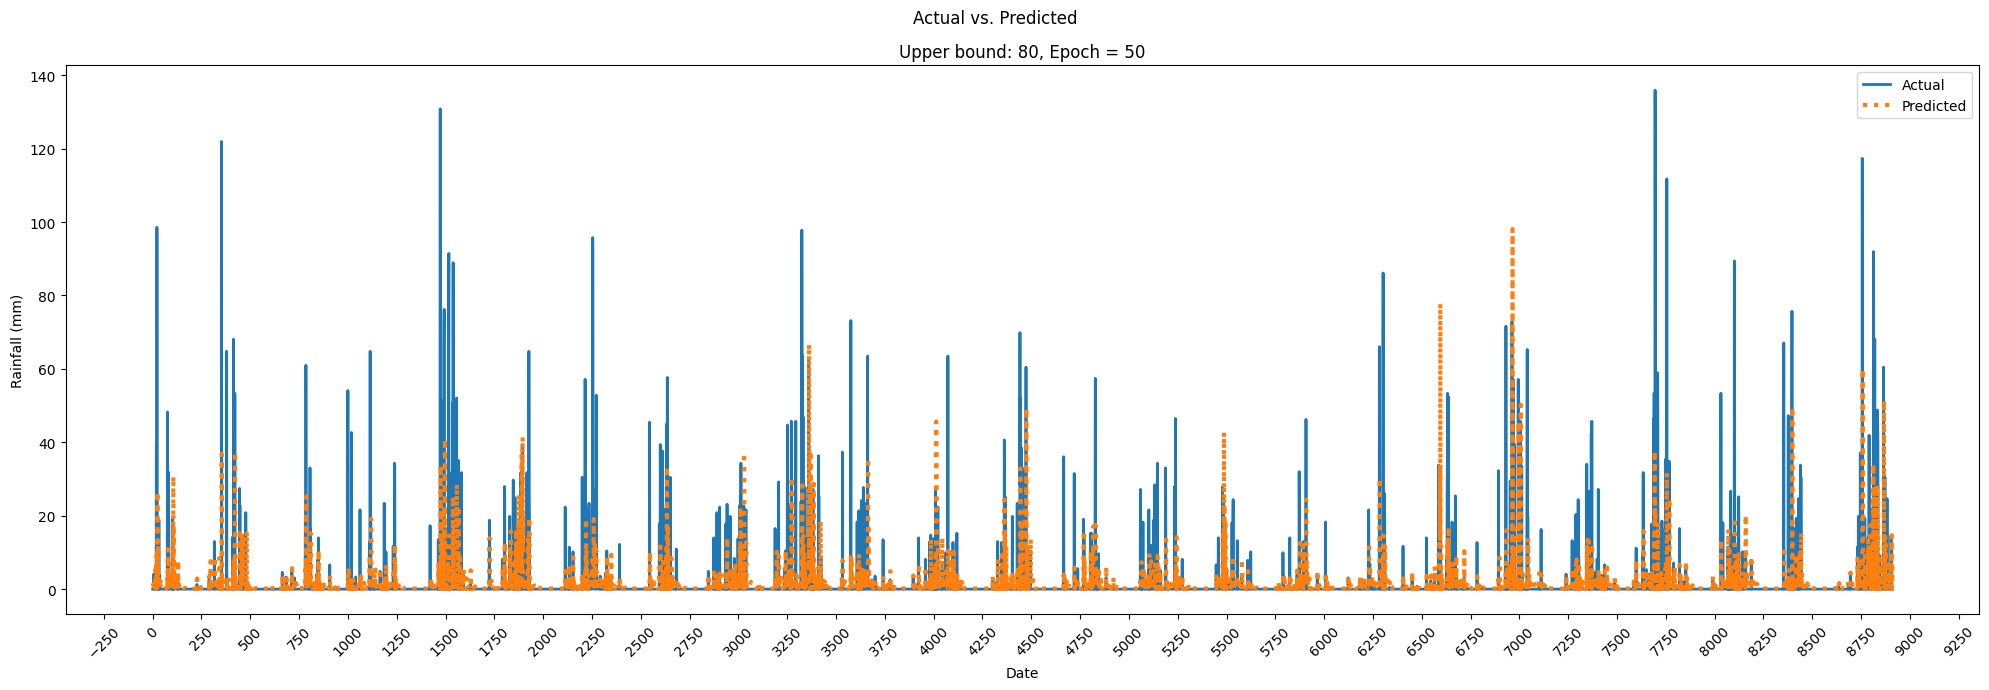

In [36]:
# Validation Plot
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(validation_compare['Actual'],linewidth=2.0)
plt.plot(validation_compare['Predicted'],linestyle=':',linewidth=3.0)
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80, Epoch = 50")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()


plt.show()

In [37]:
eval_valiation = model.evaluate(validation_compare['Actual'],validation_compare['Predicted'])
print(f"Loss: {eval_valiation[0]}")
print(f"MSE: {eval_valiation[1]}")
print(f"AUC: {eval_valiation[2]}")

279/279 [==============================] - 1s 2ms/step - loss: 21.7506 - mean_squared_error: 21.7506 - auc: 0.4865
Loss: 21.750621795654297
MSE: 21.750621795654297
AUC: 0.4865093529224396


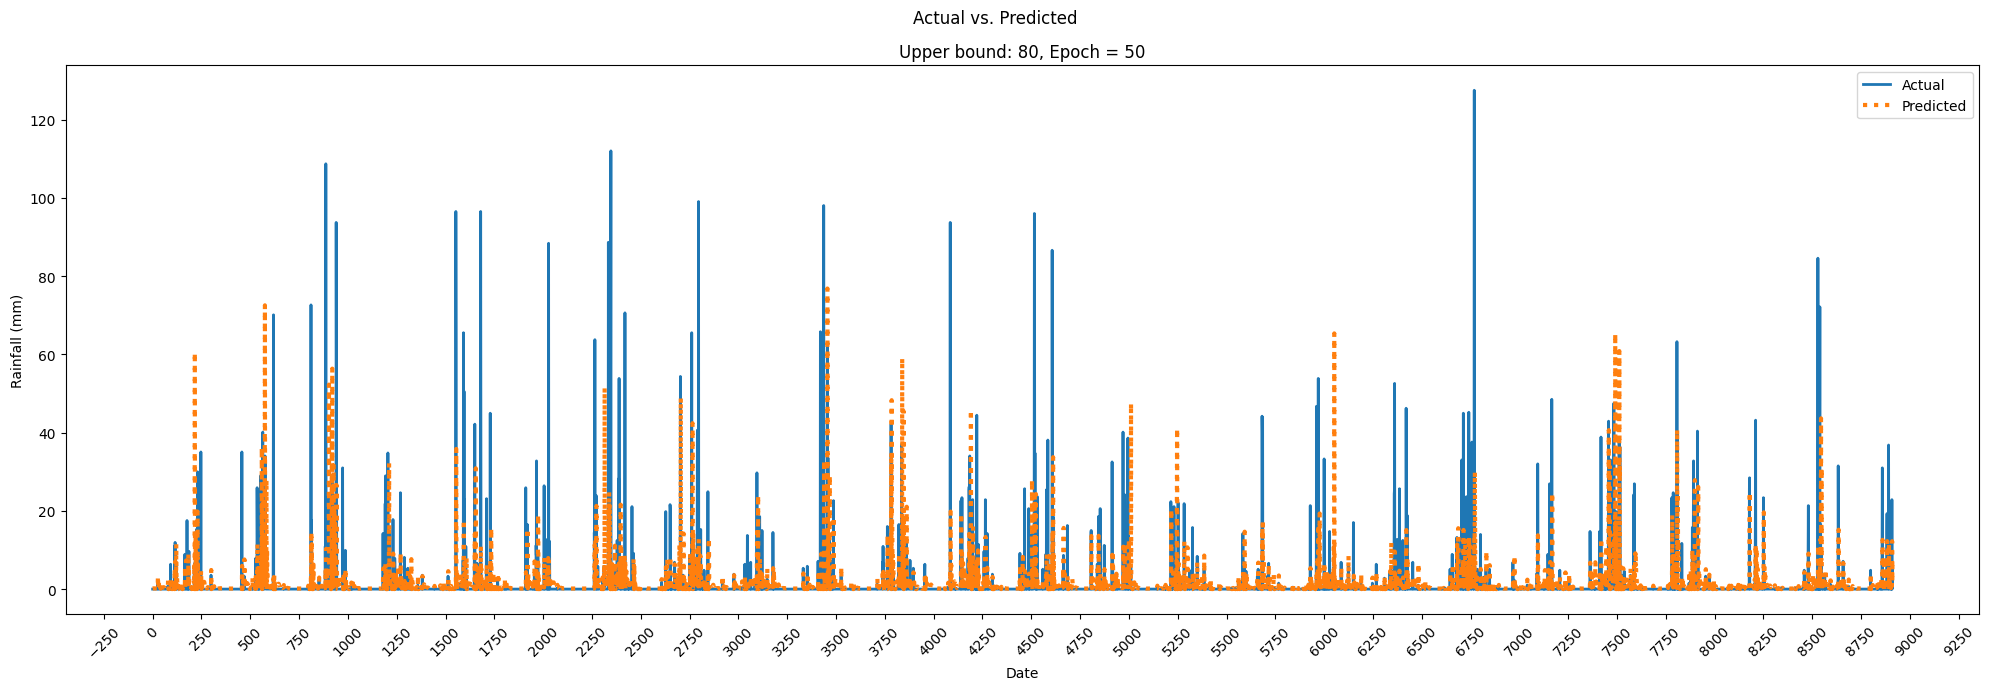

In [38]:
# Prediction Plot
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(test_compare['Actual'],linewidth=2.0)
plt.plot(test_compare['Predicted'],linestyle=':',linewidth=3.0)
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80, Epoch = 50")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()


plt.show()

In [39]:
eval_pred = model.evaluate(test_compare['Actual'],test_compare['Predicted'])
print(f"Loss: {eval_pred[0]}")
print(f"MSE: {eval_pred[1]}")
print(f"AUC: {eval_pred[2]}")

279/279 [==============================] - 1s 2ms/step - loss: 20.4939 - mean_squared_error: 20.4939 - auc: 0.4964
Loss: 20.493896484375
MSE: 20.493896484375
AUC: 0.4964269697666168


<br>

b) Days of rain prediction

- [Visualizing rain by rate](https://www.weather.gov/lox/rainrate)
- [Rain Amount Guideline](https://weatherins.com/rain-guidelines/)

In [40]:
# Validation
# Assign the date to each row
validation_compare['date'] = validation.index[90:]
validation_compare = validation_compare.set_index('date')

# Resample by month and count the number of rainning days
validation_compare_monthly = validation_compare.resample('M').agg({
    'Actual': lambda x: (x > 0).sum(),
    'Predicted': lambda x: (x > 2.54).sum()
})
# Why 2.54: validation_compare[(validation_compare['Actual'] > 0) & (validation_compare['Actual'] < 2.54)]['Actual'].head(30)


# Test
# Assign the date to each row
test_compare['date'] = test.index[90:]
test_compare = test_compare.set_index('date')

# Resample by month and count the number of rainning days
test_compare_monthly = test_compare.resample('M').agg({
    'Actual': lambda x: (x > 0).sum(),
    'Predicted': lambda x: (x > 2.54).sum()
})

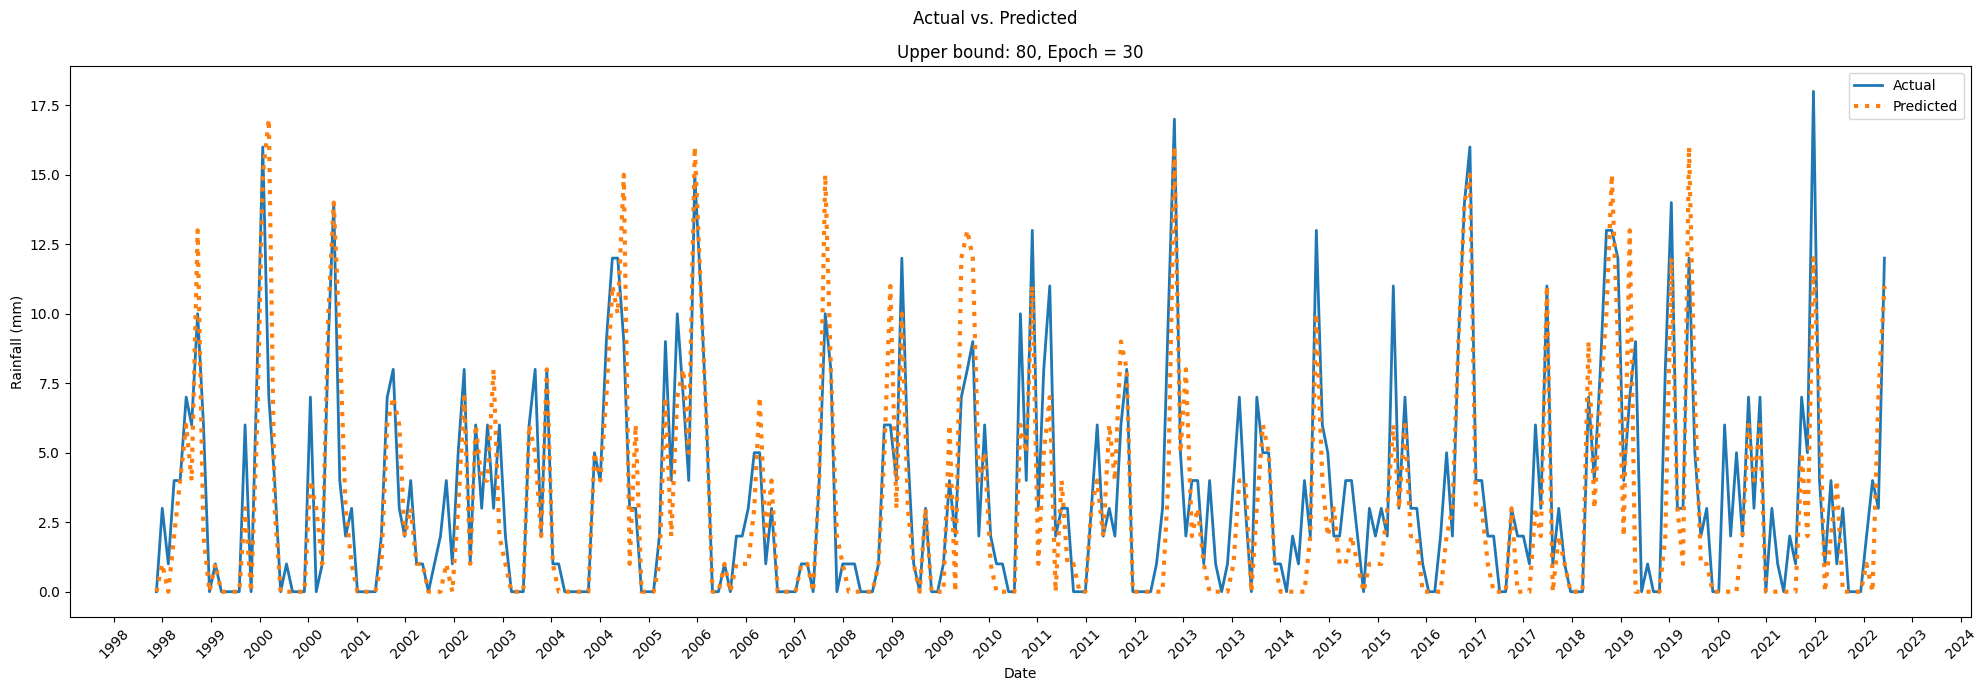

In [41]:
# For upper = 80
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(test_compare_monthly['Actual'],linewidth=2.0)
plt.plot(test_compare_monthly['Predicted'],linestyle=':',linewidth=3.0)
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80, Epoch = 30")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()


plt.show()

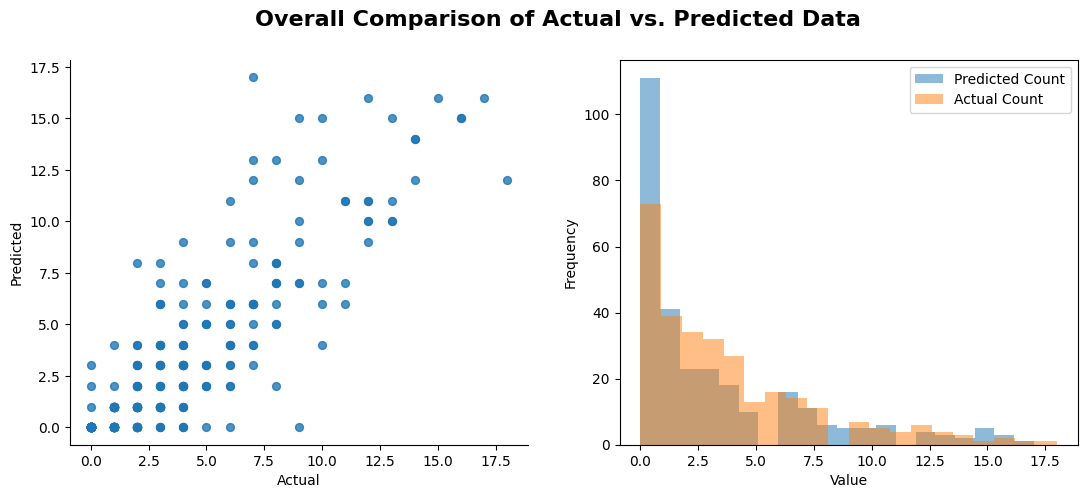

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Overall Comparison of Actual vs. Predicted Data', fontsize=16, fontweight='bold')

# Plot 1: Scatter plot
ax1.scatter(test_compare_monthly['Actual'], test_compare_monthly['Predicted'], alpha=0.8, s=32)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Histogram
ax2.hist(test_compare_monthly['Predicted'], alpha=0.5, label='Predicted Count', bins=20)  # You can adjust the number of bins
ax2.hist(test_compare_monthly['Actual'], alpha=0.5, label='Actual Count', bins=20)  # You can adjust the number of bins
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.legend()

# Show the plot
plt.show()

In [43]:
bins = [0, 2, 7, float('inf')]
test_compare_monthly['Actual_range'] = pd.cut(test_compare_monthly['Actual'], bins=bins, right=False, labels=['0-2', '3-7', '8+'])
test_compare_monthly['Predicted_range'] = pd.cut(test_compare_monthly['Predicted'], bins=bins, right=False, labels=['0-2', '3-7', '8+'])

contingency_table = pd.crosstab(test_compare_monthly['Actual_range'], test_compare_monthly['Predicted_range'])
print(contingency_table)

Predicted_range  0-2  3-7  8+
Actual_range                 
0-2              108    4   0
3-7               43   70   9
8+                 1   16  42


In [44]:
month_eval_pred = model.evaluate(test_compare_monthly['Actual'],test_compare_monthly['Predicted'])
print(f"Loss: {month_eval_pred[0]}")
print(f"MSE: {month_eval_pred[1]}")
print(f"AUC: {month_eval_pred[2]}")

10/10 [==============================] - 1s 3ms/step - loss: 50.5011 - mean_squared_error: 50.5011 - auc: 0.8071
Loss: 50.50111770629883
MSE: 50.50111770629883
AUC: 0.8070734739303589


<br>

### 2. Upper bound 80 + epoch 30:
a) Precipitation prediction

In [45]:
model = models.load_model('/content/drive/MyDrive/Extreme Precipitation/Models/model_upper80-epoch30.h5')

In [46]:
validation_predictions = model.predict(X_validation)
validation_predictions = sc.inverse_transform(validation_predictions)
validation_actual = sc.inverse_transform(y_validation.reshape(-1,1))
# Create validation dataset
validation_compare = pd.DataFrame({'Actual': validation_actual.flatten(), 'Predicted': validation_predictions.flatten()})
# Turn negative prediction to 0
validation_compare['Predicted'] = validation_compare['Predicted'].clip(lower=0)


test_predictions = model.predict(X_test)
test_predictions = sc.inverse_transform(test_predictions)
test_actual = sc.inverse_transform(y_test.reshape(-1,1))
# Create validation dataset
test_compare = pd.DataFrame({'Actual': test_actual.flatten(), 'Predicted': test_predictions.flatten()})
# Turn negative prediction to 0
test_compare['Predicted'] = test_compare['Predicted'].clip(lower=0)

279/279 [==============================] - 5s 19ms/step


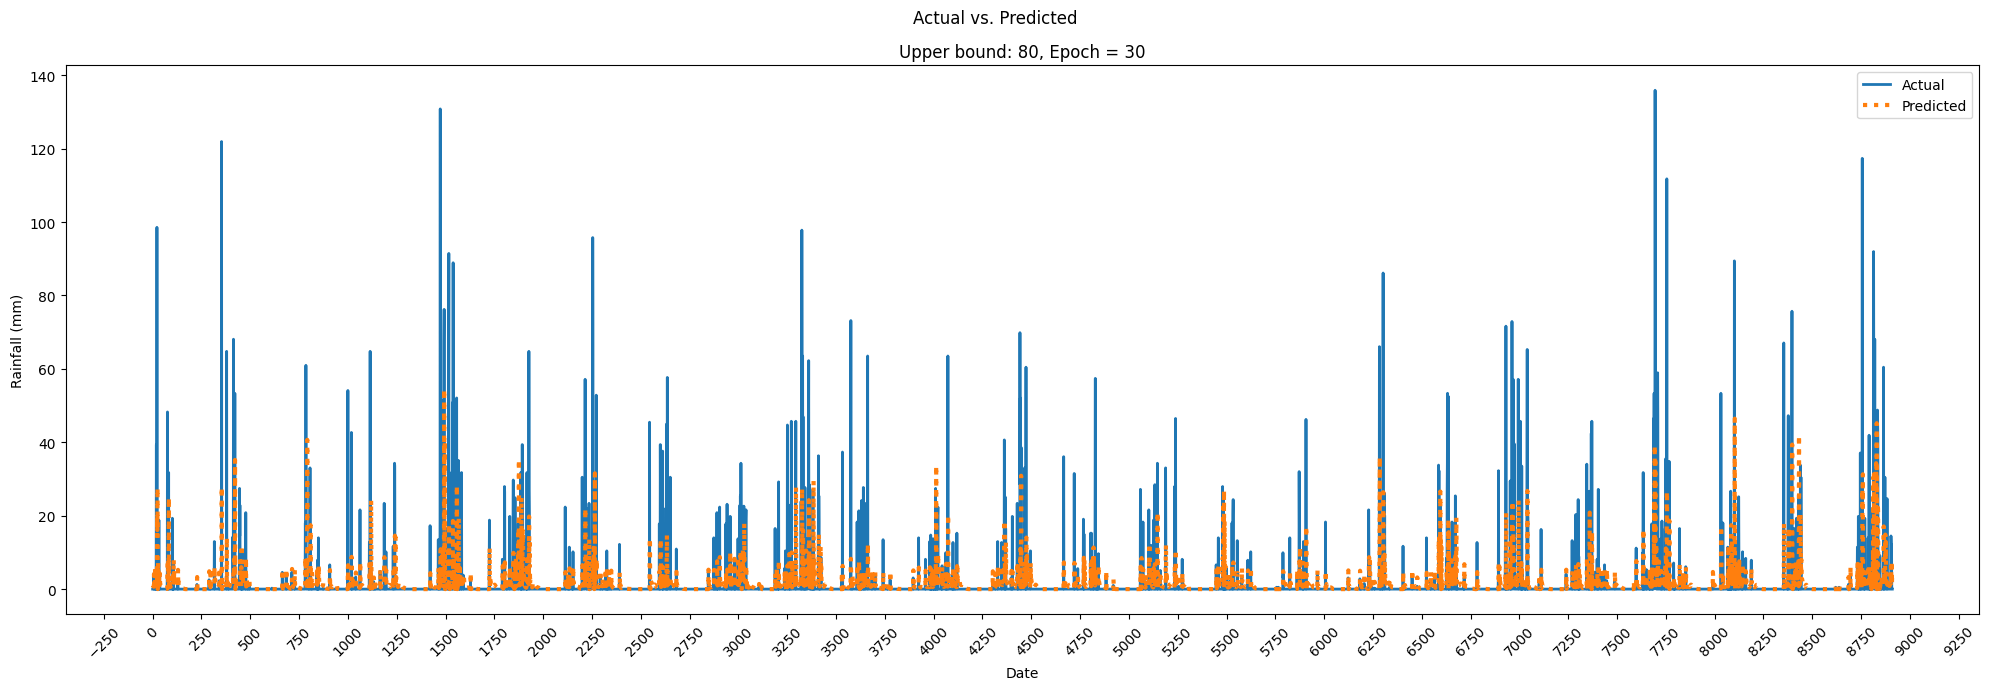

In [47]:
# For upper = 80
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(validation_compare['Actual'],linewidth=2.0)
plt.plot(validation_compare['Predicted'],linestyle=':',linewidth=3.0)
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80, Epoch = 30")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()


plt.show()

In [48]:
eval_valiation = model.evaluate(validation_compare['Actual'],validation_compare['Predicted'])
print(f"Loss: {eval_valiation[0]}")
print(f"MSE: {eval_valiation[1]}")
print(f"AUC: {eval_valiation[2]}")

279/279 [==============================] - 1s 2ms/step - loss: 11.8009 - mean_squared_error: 11.8009 - auc: 0.5502
Loss: 11.800871849060059
MSE: 11.800871849060059
AUC: 0.5502128005027771


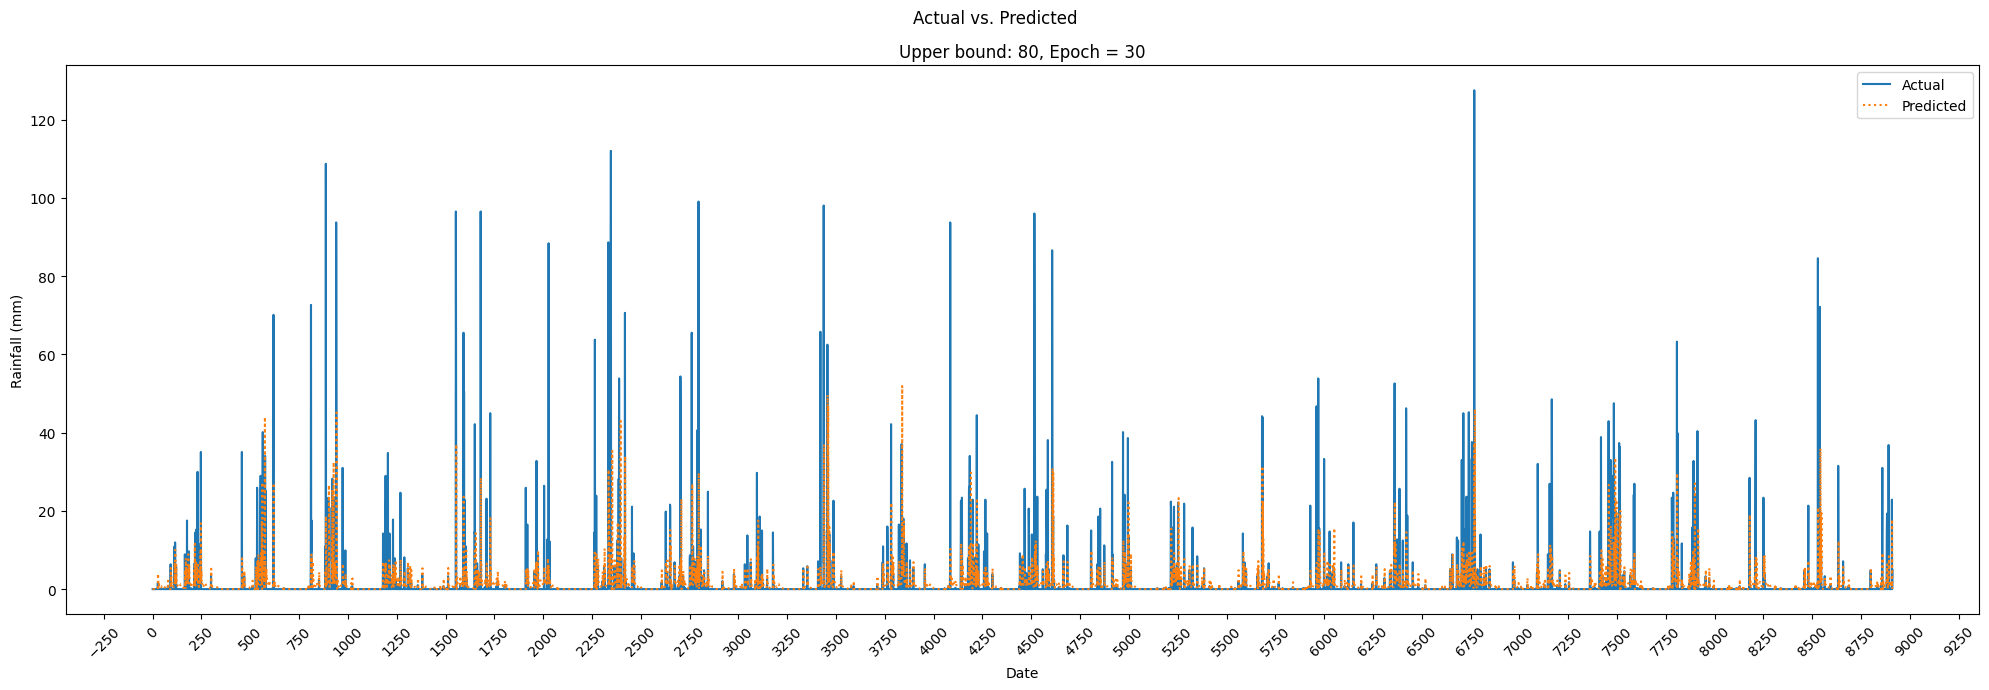

In [49]:
# For upper = 80
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(test_compare['Actual'])
plt.plot(test_compare['Predicted'],linestyle=':')
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80, Epoch = 30")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()


plt.show()

In [50]:
eval_pred = model.evaluate(test_compare['Actual'],test_compare['Predicted'])
print(f"Loss: {eval_pred[0]}")
print(f"MSE: {eval_pred[1]}")
print(f"AUC: {eval_pred[2]}")

279/279 [==============================] - 1s 2ms/step - loss: 10.0628 - mean_squared_error: 10.0628 - auc: 0.5592
Loss: 10.062776565551758
MSE: 10.062776565551758
AUC: 0.5592309236526489


<br>

b) Days of rain prediction

In [51]:
# Validation
# Assign the date to each row
validation_compare['date'] = validation.index[90:]
validation_compare = validation_compare.set_index('date')

# Resample by month and count the number of rainning days
validation_compare_monthly = validation_compare.resample('M').agg({
    'Actual': lambda x: (x > 0).sum(),
    'Predicted': lambda x: (x > 2.54).sum()
})
# Why 2.54: validation_compare[(validation_compare['Actual'] > 0) & (validation_compare['Actual'] < 2.54)]['Actual'].head(30)


# Test
# Assign the date to each row
test_compare['date'] = test.index[90:]
test_compare = test_compare.set_index('date')

# Resample by month and count the number of rainning days
test_compare_monthly = test_compare.resample('M').agg({
    'Actual': lambda x: (x > 0).sum(),
    'Predicted': lambda x: (x > 2.54).sum()
})

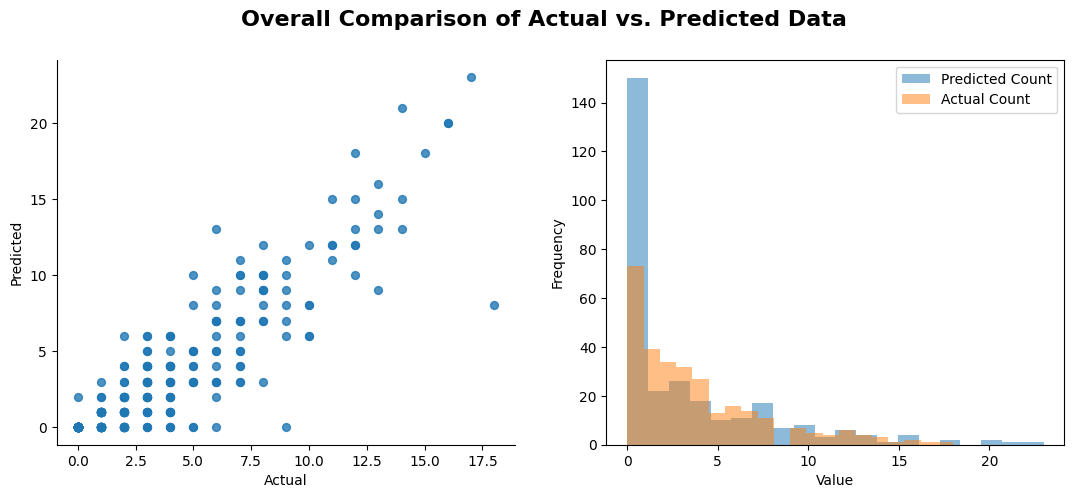

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Overall Comparison of Actual vs. Predicted Data', fontsize=16, fontweight='bold')

# Plot 1: Scatter plot
ax1.scatter(test_compare_monthly['Actual'], test_compare_monthly['Predicted'], alpha=0.8, s=32)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Histogram
ax2.hist(test_compare_monthly['Predicted'], alpha=0.5, label='Predicted Count', bins=20)  # You can adjust the number of bins
ax2.hist(test_compare_monthly['Actual'], alpha=0.5, label='Actual Count', bins=20)  # You can adjust the number of bins
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.legend()

# Show the plot
plt.show()

In [53]:
bins = [0, 2, 7, float('inf')]
test_compare_monthly['Actual_range'] = pd.cut(test_compare_monthly['Actual'], bins=bins, right=False, labels=['0-2', '3-7', '8+'])
test_compare_monthly['Predicted_range'] = pd.cut(test_compare_monthly['Predicted'], bins=bins, right=False, labels=['0-2', '3-7', '8+'])

contingency_table = pd.crosstab(test_compare_monthly['Actual_range'], test_compare_monthly['Predicted_range'])
print(contingency_table)

Predicted_range  0-2  3-7  8+
Actual_range                 
0-2              108    4   0
3-7               41   72   9
8+                 1   11  47


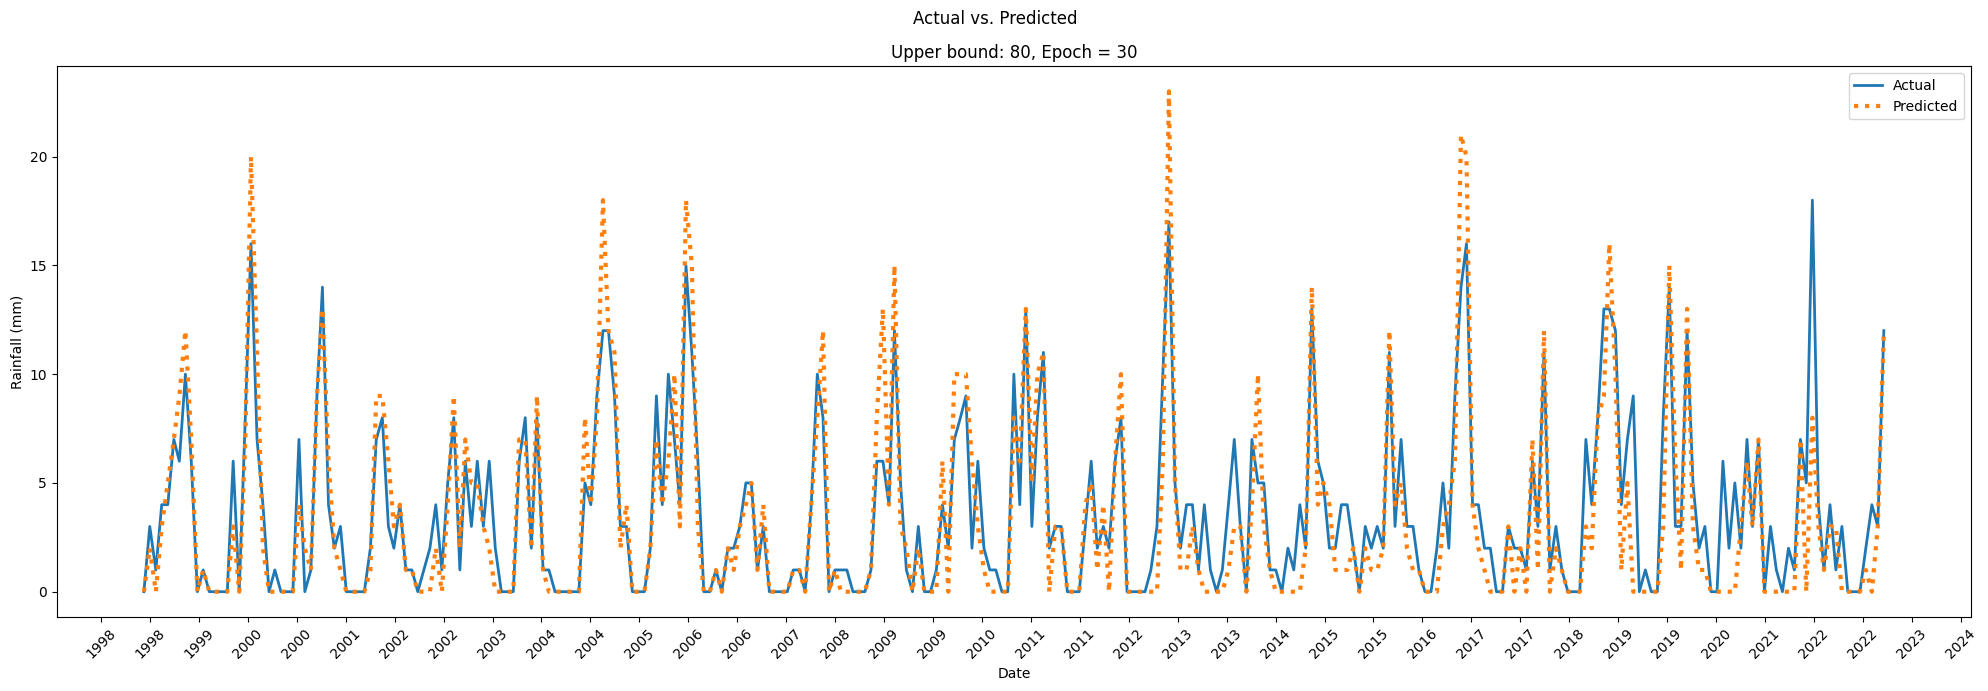

In [54]:
# For upper = 80
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(test_compare_monthly['Actual'],linewidth=2.0)
plt.plot(test_compare_monthly['Predicted'],linestyle=':',linewidth=3.0)
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80, Epoch = 30")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()


plt.show()

In [55]:
month_eval_pred = model.evaluate(test_compare_monthly['Actual'],test_compare_monthly['Predicted'])
print(f"Loss: {month_eval_pred[0]}")
print(f"MSE: {month_eval_pred[1]}")
print(f"AUC: {month_eval_pred[2]}")

10/10 [==============================] - 1s 3ms/step - loss: 13.1024 - mean_squared_error: 13.1024 - auc: 0.8158
Loss: 13.102447509765625
MSE: 13.102447509765625
AUC: 0.8158062696456909
